In [1]:
import os, json

from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv(), override=True)

True

In [2]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///chinook.db")
print(db.dialect)
print(db.get_usable_table_names())


sqlite
['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


## Define tools for the agent

We will define a few tools that the agent will use to interact with the database.

1. `list_tables_tool`: Fetch the available tables from the database
2. `get_schema_tool`: Fetch the DDL for a table
3. `db_query_tool`: Execute the query and fetch the results OR return an error message if the query fails

For the first two tools, we will grab them from the `SQLDatabaseToolkit`, also available in the `langchain_community` package.

In [7]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain_openai import AzureChatOpenAI

llm = AzureChatOpenAI(
    api_key=os.environ["AZURE_OPENAI_API_KEY"],
    azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
    api_version=os.environ["AZURE_OPENAI_API_VERSION"],   # tool_choice="required" is only supported in 2024-06-01 and later
    azure_deployment="gpt-4o",
    streaming=True,
    temperature=0
)

toolkit = SQLDatabaseToolkit(db=db, llm=llm)
tools = toolkit.get_tools()

for tool in tools:
    print(tool.name)
    print(f"\t{tool.description}\n")

sql_db_query
	Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.

sql_db_schema
	Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3

sql_db_list_tables
	Input is an empty string, output is a comma-separated list of tables in the database.

sql_db_query_checker
	Use this tool to double check if your query is correct before executing it. Always use this tool before executing a query with sql_db_query!



In [34]:
from typing import Any

from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda, RunnableWithFallbacks
from langgraph.prebuilt import ToolNode


def create_tool_node_with_fallback(tools: list) -> RunnableWithFallbacks[Any, dict]:
    """
    Create a ToolNode with a fallback to handle errors and surface them to the agent.
    """
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }

In [41]:
from langchain_core.messages import HumanMessage, AIMessage

# user_input = "Get the first 10 tracks with the genre 'Rock'"
# user_input = " Finding the top 5 artists with the most albums:"
user_input = "Find albums released by artists who have more than 5 albums"

messages = [HumanMessage(content=user_input)]
messages

[HumanMessage(content='Find albums released by artists who have more than 5 albums', additional_kwargs={}, response_metadata={})]

In [42]:
ai_msg = AIMessage(
                content="",
                tool_calls=[
                    {
                        "name": "sql_db_list_tables",
                        "args": {},
                        "id": "tool_abcd123",
                    }
                ],
            )

messages.append(ai_msg)
messages

[HumanMessage(content='Find albums released by artists who have more than 5 albums', additional_kwargs={}, response_metadata={}),
 AIMessage(content='', additional_kwargs={}, response_metadata={}, tool_calls=[{'name': 'sql_db_list_tables', 'args': {}, 'id': 'tool_abcd123', 'type': 'tool_call'}])]

In [ ]:
from langchain_core.messages import ToolMessage

tool_calls = messages[-1].tool_calls
tool_mapping = {t.name: t for t in tools}

for tool_call in tool_calls:
    tool = tool_mapping[tool_call["name"].lower()]
    tool_output = tool.invoke(tool_call["args"])
    print(f"Tool Output of listing tables: \n{tool_output}\n\n")
    messages.append(ToolMessage(tool_call_id=tool_call['id'], name=tool_call['name'], content=str(tool_output)))
messages
    

Tool Output of listing tables: 
Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track




[HumanMessage(content='Find albums released by artists who have more than 5 albums', additional_kwargs={}, response_metadata={}),
 AIMessage(content='', additional_kwargs={}, response_metadata={}, tool_calls=[{'name': 'sql_db_list_tables', 'args': {}, 'id': 'tool_abcd123', 'type': 'tool_call'}]),
 ToolMessage(content='Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track', name='sql_db_list_tables', tool_call_id='tool_abcd123')]

## Below Cell does the same as above cell using `ToolNode`

In [ ]:
# OR
# Use ToolNode to invoke the tool

list_tables_tool = next(tool for tool in tools if tool.name == "sql_db_list_tables")
table_names = ToolNode([list_tables_tool]).invoke(messages)
messages.append(table_names)
messages

[HumanMessage(content='Find albums released by artists who have more than 5 albums', additional_kwargs={}, response_metadata={}),
 AIMessage(content='', additional_kwargs={}, response_metadata={}, tool_calls=[{'name': 'sql_db_list_tables', 'args': {}, 'id': 'tool_abcd123', 'type': 'tool_call'}]),
 [ToolMessage(content='Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track', name='sql_db_list_tables', tool_call_id='tool_abcd123')]]

In [ ]:
# Get schema relevant to the user input

get_schema_tool = next(tool for tool in tools if tool.name == "sql_db_schema")
model_get_schema  = llm.bind_tools([get_schema_tool])
response = model_get_schema.invoke(messages)

messages.append(response)
messages[-1].tool_calls

[{'name': 'sql_db_schema',
  'args': {'table_names': 'Album, Artist'},
  'id': 'call_QHGMRX4u0UO4okezjo5KL2YE',
  'type': 'tool_call'}]

In [ ]:
from langchain_core.messages import ToolMessage

tool_calls = messages[-1].tool_calls
tool_mapping = {t.name: t for t in tools}

for tool_call in tool_calls:
    tool = tool_mapping[tool_call["name"].lower()]
    tool_output = tool.invoke(tool_call["args"])
    print(f"Tool Output of listing tables: \n{tool_output}\n\n")
    messages.append(ToolMessage(tool_call_id=tool_call['id'], name=tool_call['name'], content=str(tool_output)))
messages


# # OR

# table_names = ToolNode([get_schema_tool]).invoke(messages)
# messages.append(table_names)
# messages    

Tool Output of listing tables: 

CREATE TABLE "Album" (
	"AlbumId" INTEGER NOT NULL, 
	"Title" NVARCHAR(160) NOT NULL, 
	"ArtistId" INTEGER NOT NULL, 
	PRIMARY KEY ("AlbumId"), 
	FOREIGN KEY("ArtistId") REFERENCES "Artist" ("ArtistId")
)

/*
3 rows from Album table:
AlbumId	Title	ArtistId
1	For Those About To Rock We Salute You	1
2	Balls to the Wall	2
3	Restless and Wild	2
*/


CREATE TABLE "Artist" (
	"ArtistId" INTEGER NOT NULL, 
	"Name" NVARCHAR(120), 
	PRIMARY KEY ("ArtistId")
)

/*
3 rows from Artist table:
ArtistId	Name
1	AC/DC
2	Accept
3	Aerosmith
*/




[HumanMessage(content='Find albums released by artists who have more than 5 albums', additional_kwargs={}, response_metadata={}),
 AIMessage(content='', additional_kwargs={}, response_metadata={}, tool_calls=[{'name': 'sql_db_list_tables', 'args': {}, 'id': 'tool_abcd123', 'type': 'tool_call'}]),
 ToolMessage(content='Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track', name='sql_db_list_tables', tool_call_id='tool_abcd123'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_QHGMRX4u0UO4okezjo5KL2YE', 'function': {'arguments': '{"table_names":"Album, Artist"}', 'name': 'sql_db_schema'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_b705f0c291'}, id='run-6cc35f94-d12f-4652-a063-4e65a10a91a2-0', tool_calls=[{'name': 'sql_db_schema', 'args': {'table_names': 'Album, Artist'}, 'id': 'call_QHGMRX4u0UO4okezjo5KL2YE', 'ty

In [15]:
from langchain_core.tools import tool
from pydantic import BaseModel, Field

class GenerateQuery(BaseModel):
    """Generate a query based on the question and schema."""
    query: str = Field(..., description="The generated query to run on the sqlite3 database.")


@tool(args_schema=GenerateQuery)
def db_query_tool(query: str) -> str:
    """
    Execute a SQL query against the database and get back the result.
    If the query is not correct, an error message will be returned.
    If an error is returned, rewrite the query, check the query, and try again.
    """
    result = db.run_no_throw(query)
    if not result:
        return "Error: Query failed. Please rewrite your query and try again."
    if result.startswith("Error:"):
        return result + "\nPlease rewrite your query and try again."
    return result   # above if condition is not required as "run_no_throw returns error too"


sql_query = db_query_tool.invoke('SELECT * FROM Artist LIMIT 10;')
print(sql_query)

[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]


In [ ]:
from langchain_core.prompts import ChatPromptTemplate
# from pydantic import BaseModel, Field

QUERY_GEN_SYSTEM_PROMPT = """You are a SQL expert with a strong attention to detail.

You have access to a SQLite database through a db_query_tool that can execute queries on the database.
Given an input question, call the tool by generating a syntactically correct SQLite query without wrapping it in any sql or markers by using "GenerateQuery" tool schema definition.
If the query fails, you will be prompted to rewrite the query and try again. 
If the query is correct, you will get the result of the query, which you can then use to answer the question.

When extracting the query argument for the tool, follow the following INSTRUCTIONS:

- Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 50 results.
- ALWAYS ORDER the results by a relevant column to return the most interesting examples in the database, preferrably in descending order of numeric values using DESC.
- Never query for all the columns from a specific table, only ask for the relevant columns given the question.
- If you get an error while executing a query, you will be prompted to rewrite the query and try again.
- NEVER make stuff up if you don't have enough information to answer the query... just say you don't have enough information or ask for clarification.
- DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database."""
    
    
query_gen_prompt = ChatPromptTemplate.from_messages(
    [("system", QUERY_GEN_SYSTEM_PROMPT), ("human", "{messages}")]
)
query_gen_prompt

ChatPromptTemplate(input_variables=['messages'], input_types={}, partial_variables={}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template='You are a SQL expert with a strong attention to detail.\n\nYou have access to a SQLite database through a db_query_tool that can execute queries on the database.\nGiven an input question, call the tool by generating a syntactically correct SQLite query without wrapping it in any sql or markers by using "GenerateQuery" tool schema definition.\nIf the query fails, you will be prompted to rewrite the query and try again. \nIf the query is correct, you will get the result of the query, which you can then use to answer the question.\n\n\n\nWhen extracting the query argument for the tool, follow the following INSTRUCTIONS:\n\n- Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 50 results.\n- ALWAYS ORDER the results by 

In [18]:
# query_gen = query_gen_prompt | llm
query_gen = query_gen_prompt | llm.bind_tools([db_query_tool])

query_response = query_gen.invoke({'messages': messages})
print(query_response)
query_response.tool_calls

content='' additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_Jlf7VIUAoRWLx5jtxnzIyy6c', 'function': {'arguments': '{"query":"SELECT Artist.Name, Album.Title FROM Artist JOIN Album ON Artist.ArtistId = Album.ArtistId WHERE Artist.ArtistId IN (SELECT ArtistId FROM Album GROUP BY ArtistId HAVING COUNT(AlbumId) > 5) ORDER BY Artist.Name, Album.Title LIMIT 50"}', 'name': 'db_query_tool'}, 'type': 'function'}]} response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_b705f0c291'} id='run-355bbe21-b4e4-4bd1-993d-f3ef79227ecc-0' tool_calls=[{'name': 'db_query_tool', 'args': {'query': 'SELECT Artist.Name, Album.Title FROM Artist JOIN Album ON Artist.ArtistId = Album.ArtistId WHERE Artist.ArtistId IN (SELECT ArtistId FROM Album GROUP BY ArtistId HAVING COUNT(AlbumId) > 5) ORDER BY Artist.Name, Album.Title LIMIT 50'}, 'id': 'call_Jlf7VIUAoRWLx5jtxnzIyy6c', 'type': 'tool_call'}]


[{'name': 'db_query_tool',
  'args': {'query': 'SELECT Artist.Name, Album.Title FROM Artist JOIN Album ON Artist.ArtistId = Album.ArtistId WHERE Artist.ArtistId IN (SELECT ArtistId FROM Album GROUP BY ArtistId HAVING COUNT(AlbumId) > 5) ORDER BY Artist.Name, Album.Title LIMIT 50'},
  'id': 'call_Jlf7VIUAoRWLx5jtxnzIyy6c',
  'type': 'tool_call'}]

In [20]:
messages.append(query_response)
messages

[HumanMessage(content='Find albums released by artists who have more than 5 albums', additional_kwargs={}, response_metadata={}),
 AIMessage(content='', additional_kwargs={}, response_metadata={}, tool_calls=[{'name': 'sql_db_list_tables', 'args': {}, 'id': 'tool_abcd123', 'type': 'tool_call'}]),
 ToolMessage(content='Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track', name='sql_db_list_tables', tool_call_id='tool_abcd123'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_wjlGipEw60973ezMtcoV1VjK', 'function': {'arguments': '{"table_names":"Album, Artist"}', 'name': 'sql_db_schema'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_b705f0c291'}, id='run-edef5e55-ff74-4b8b-a4d8-cce8abca8220-0', tool_calls=[{'name': 'sql_db_schema', 'args': {'table_names': 'Album, Artist'}, 'id': 'call_wjlGipEw60973ezMtcoV1VjK', 'ty

In [21]:
from langgraph.prebuilt import ToolNode

query_tool_node = ToolNode([db_query_tool])
db_result = query_tool_node.invoke(messages)
db_result

[ToolMessage(content='[(\'Deep Purple\', \'Come Taste The Band\'), (\'Deep Purple\', \'Deep Purple In Rock\'), (\'Deep Purple\', \'Fireball\'), (\'Deep Purple\', "Knocking at Your Back Door: The Best Of Deep Purple in the 80\'s"), (\'Deep Purple\', \'MK III The Final Concerts [Disc 1]\'), (\'Deep Purple\', \'Machine Head\'), (\'Deep Purple\', \'Purpendicular\'), (\'Deep Purple\', \'Slaves And Masters\'), (\'Deep Purple\', \'Stormbringer\'), (\'Deep Purple\', \'The Battle Rages On\'), (\'Deep Purple\', \'The Final Concerts (Disc 2)\'), (\'Iron Maiden\', \'A Matter of Life and Death\'), (\'Iron Maiden\', \'A Real Dead One\'), (\'Iron Maiden\', \'A Real Live One\'), (\'Iron Maiden\', \'Brave New World\'), (\'Iron Maiden\', \'Dance Of Death\'), (\'Iron Maiden\', \'Fear Of The Dark\'), (\'Iron Maiden\', \'Iron Maiden\'), (\'Iron Maiden\', \'Killers\'), (\'Iron Maiden\', \'Live After Death\'), (\'Iron Maiden\', \'Live At Donington 1992 (Disc 1)\'), (\'Iron Maiden\', \'Live At Donington 1992 

In [25]:
messages.append(db_result)
messages

[HumanMessage(content='Find albums released by artists who have more than 5 albums', additional_kwargs={}, response_metadata={}),
 AIMessage(content='', additional_kwargs={}, response_metadata={}, tool_calls=[{'name': 'sql_db_list_tables', 'args': {}, 'id': 'tool_abcd123', 'type': 'tool_call'}]),
 ToolMessage(content='Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track', name='sql_db_list_tables', tool_call_id='tool_abcd123'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_wjlGipEw60973ezMtcoV1VjK', 'function': {'arguments': '{"table_names":"Album, Artist"}', 'name': 'sql_db_schema'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_b705f0c291'}, id='run-edef5e55-ff74-4b8b-a4d8-cce8abca8220-0', tool_calls=[{'name': 'sql_db_schema', 'args': {'table_names': 'Album, Artist'}, 'id': 'call_wjlGipEw60973ezMtcoV1VjK', 'ty

In [26]:
format_system = """ 
You will receive a user input and AI response for that input. Please present the response in a readable format for the user.
"""

format_prompt = ChatPromptTemplate.from_messages(
    [("system", format_system), ("human", "User Input: {user_input}"), ("ai", "AI Response: {answer}")]
)

answer_gen = format_prompt | llm

answer = answer_gen.invoke({'user_input': messages[0], 'answer': messages[-1]})

# print(answer.content)

from IPython.display import Markdown
display(Markdown(answer.content))

Here is a list of albums released by artists who have more than 5 albums:

**Deep Purple:**
- Come Taste The Band
- Deep Purple In Rock
- Fireball
- Knocking at Your Back Door: The Best Of Deep Purple in the 80's
- MK III The Final Concerts [Disc 1]
- Machine Head
- Purpendicular
- Slaves And Masters
- Stormbringer
- The Battle Rages On
- The Final Concerts (Disc 2)

**Iron Maiden:**
- A Matter of Life and Death
- A Real Dead One
- A Real Live One
- Brave New World
- Dance Of Death
- Fear Of The Dark
- Iron Maiden
- Killers
- Live After Death
- Live At Donington 1992 (Disc 1)
- Live At Donington 1992 (Disc 2)
- No Prayer For The Dying
- Piece Of Mind
- Powerslave
- Rock In Rio [CD1]
- Rock In Rio [CD2]
- Seventh Son of a Seventh Son
- Somewhere in Time
- The Number of The Beast
- The X Factor
- Virtual XI

**Led Zeppelin:**
- BBC Sessions [Disc 1] [Live]
- BBC Sessions [Disc 2] [Live]
- Coda
- Houses Of The Holy
- IV
- In Through The Out Door
- Led Zeppelin I
- Led Zeppelin II
- Led Zeppelin III
- Physical Graffiti [Disc 1]
- Physical Graffiti [Disc 2]
- Presence
- The Song Remains The Same (Disc 1)
- The Song Remains The Same (Disc 2)

**Metallica:**
- ...And Justice For All
- Black Album
- Garage Inc. (Disc 1)
- Garage Inc. (Disc 2)

# Define a Graph
## Visualize and Run the workflow

## Sqlite

A good starting point here is the [SqliteSaver checkpointer](https://langchain-ai.github.io/langgraph/concepts/low_level/#checkpointer).

Sqlite is a [small, fast, highly popular](https://x.com/karpathy/status/1819490455664685297) SQL database. 
 
If we supply `":memory:"` it creates an in-memory Sqlite database.

In [27]:
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver

# # Transient in-memory database. This database exists only in RAM and will be lost once the connection is closed or the program terminates. 
# conn = sqlite3.connect(":memory:", check_same_thread = False)
# checkpointer = SqliteSaver(conn)

# Save to local db instead of :memory: to persist state 
db_path = "checkpointer_db/state.db"
conn = sqlite3.connect(db_path, check_same_thread=False)
checkpointer = SqliteSaver(conn)

In [28]:
from typing import Annotated, Literal

from langchain_core.messages import AIMessage
from langchain_openai import AzureChatOpenAI

from pydantic import BaseModel, Field
from typing_extensions import TypedDict

from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import AnyMessage, add_messages, MessagesState

# MessagesState takes care of this, so we do not need to define this
# 
# class State(TypedDict):
#     messages: Annotated[list[AnyMessage], add_messages]

In [57]:
# Add a node for the first tool call
def list_tables_ai_call(state: MessagesState) -> dict[str, list[AIMessage]]:
    return {
        "messages": [
            AIMessage(
                content="",
                tool_calls=[
                    {
                        "name": "sql_db_list_tables",
                        "args": {},
                        "id": "tool_abcd123",
                    }
                ],
            )
        ]
    }

In [67]:
def get_db_schema(state: MessagesState):  
    get_schema_tool = next(tool for tool in tools if tool.name == "sql_db_schema")
    model_get_schema  = llm.bind_tools([get_schema_tool])
    
    messages = state["messages"]
    db_schema = model_get_schema.invoke(messages)
    return {"messages": [db_schema]}

In [68]:
query_gen = query_gen_prompt | llm.bind_tools([db_query_tool])


def query_agent_node(state: MessagesState) -> MessagesState:
    messages = state["messages"]
    query_response = query_gen.invoke({'messages': messages})
    return {"messages": [query_response]}

In [75]:
def db_tool_node(state: MessagesState):
    tool_calls = state["messages"][-1].tool_calls        
    tools_mapping = {"db_query_tool": db_query_tool}
    
    results = []        
    for tool_call in tool_calls:
        print(f"Calling: {tool_call}")
        if not tool_call['name'] in tools_mapping.keys():     # check for bad tool name from LLM
            print("\n ....bad tool name....")
            output = "bad tool name, retry"  # instruct LLM to retry if bad
        else:
            tool = tools_mapping[tool_call["name"].lower()]
            output = tool.invoke(tool_call["args"])        
        results.append(ToolMessage(tool_call_id=tool_call['id'], name=tool_call['name'], content=str(output)))
    # print(f"Tool Results: {results}")
    state['messages'] = results
    return state

In [78]:
def tool_check(state: MessagesState) -> Literal["query_db", "__end__"]:
    messages = state["messages"]
    last_message = messages[-1]
    
    if len(last_message.tool_calls) > 0:
        return "query_db"
    else:
        return "__end__"
    

In [77]:
def db_tool_node(state: MessagesState):
    tool_calls = state["messages"][-1].tool_calls
    
    tool_mapping = {"db_query_tool": db_query_tool}
    results = []
    
    for tool_call in tool_calls:
        print(f"Calling: {tool_call}")
        if not tool_call['name'] in tool_mapping.keys():     # check for bad tool name from LLM
            print("\n ....bad tool name....")
            output = "bad tool name, retry"  # instruct LLM to retry if bad
        else:
            tool = tool_mapping[tool_call["name"].lower()]
            output = tool.invoke(tool_call["args"])        
        results.append(ToolMessage(tool_call_id=tool_call['id'], name=tool_call['name'], content=str(output)))
    state['messages'] = results
    return state



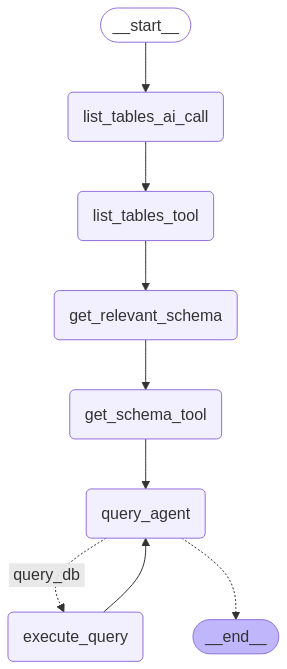

In [80]:
# Define a new graph
workflow = StateGraph(MessagesState)



workflow.add_node("list_tables_ai_call", list_tables_ai_call)
workflow.add_node(
    "list_tables_tool", create_tool_node_with_fallback([list_tables_tool])
)

workflow.add_node("get_relevant_schema", get_db_schema)
workflow.add_node("get_schema_tool", create_tool_node_with_fallback([get_schema_tool]))

workflow.add_node("query_agent", query_agent_node)
workflow.add_node("execute_query", db_tool_node)



workflow.add_edge(START, "list_tables_ai_call")
workflow.add_edge("list_tables_ai_call", "list_tables_tool") 
workflow.add_edge("list_tables_tool", "get_relevant_schema")
workflow.add_edge("get_relevant_schema", "get_schema_tool")
workflow.add_edge("get_schema_tool", "query_agent")
workflow.add_conditional_edges(
    "query_agent",
    tool_check,
    {"query_db": "execute_query", "__end__": END}
)
workflow.add_edge("execute_query", "query_agent")


# Compile the workflow into a runnable
sql_graph = workflow.compile(checkpointer=checkpointer)

from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        sql_graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [ ]:
import uuid

session_id = str(uuid.uuid4())
config = {"configurable": {"thread_id": session_id}}
print(f"Session ID: {session_id}\n")

from langchain_core.messages import HumanMessage
user_input = "Hi, can you tell me the names of popular albums in the database?"

result = sql_graph.invoke(
    {"messages": [HumanMessage(content=user_input)]},
    config=config
)
result['messages']

Session ID: 5c45e982-d969-4327-8d3d-df60daedd4e3

Calling: {'name': 'db_query_tool', 'args': {'query': 'SELECT Title FROM Album ORDER BY AlbumId DESC LIMIT 50'}, 'id': 'call_OgwFsN49CdTQdtpPS60T6W3P', 'type': 'tool_call'}


[HumanMessage(content='Hi, can you tell me the names of popular albums in the database?', additional_kwargs={}, response_metadata={}, id='86409862-8738-4453-85da-bc3b8083eff5'),
 AIMessage(content='', additional_kwargs={}, response_metadata={}, id='be5d499f-73f9-465a-9cbb-bbe2c4af3e8e', tool_calls=[{'name': 'sql_db_list_tables', 'args': {}, 'id': 'tool_abcd123', 'type': 'tool_call'}]),
 ToolMessage(content='Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track', name='sql_db_list_tables', id='5e883f97-7dd3-4241-8731-14989da83942', tool_call_id='tool_abcd123'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_6WPDuiR2nIwmsuXDrpHXr6oX', 'function': {'arguments': '{"table_names":"Album"}', 'name': 'sql_db_schema'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_b705f0c291'}, id='run-b6829b9d-46d1-4fcb-ac9f-61901976340d-

In [84]:
display(Markdown(result['messages'][-1].content))

Here are some popular album titles from the database:

1. Koyaanisqatsi (Soundtrack from the Motion Picture)
2. Mozart: Chamber Music
3. Monteverdi: L'Orfeo
4. Schubert: The Late String Quartets & String Quintet (3 CDs)
5. Respighi: Pines of Rome
6. Locatelli: Concertos for Violin, Strings and Continuo, Vol. 3
7. Great Recordings of the Century - Schubert: Schwanengesang, 4 Lieder
8. Liszt - 12 Études D'Execution Transcendante
9. Great Recordings of the Century: Paganini's 24 Caprices
10. Nielsen: The Six Symphonies

If you need more information or additional titles, feel free to ask!

In [ ]:
user_input = "Which album has the most tracks?"

result = sql_graph.invoke(
    {"messages": [HumanMessage(content=user_input)]},
    config=config
)
display(Markdown(result['messages'][-1].content))
# result['messages']

Calling: {'name': 'db_query_tool', 'args': {'query': 'SELECT DISTINCT Artist.Name FROM Artist JOIN Album ON Artist.ArtistId = Album.ArtistId ORDER BY Artist.Name'}, 'id': 'call_19M2myBRmJfsMbAhrl39hQc4', 'type': 'tool_call'}


Here are some artists who have an album in the database:

1. AC/DC
2. Aaron Copland & London Symphony Orchestra
3. Aaron Goldberg
4. Academy of St. Martin in the Fields & Sir Neville Marriner
5. Accept
6. Aerosmith
7. Aisha Duo
8. Alanis Morissette
9. Alice In Chains
10. Amy Winehouse

If you need more information or additional names, feel free to ask!

In [87]:
for msg in result['messages']:
    print(msg.type)

human
ai
tool
ai
tool
ai
tool
ai
human
ai
tool
ai
tool
tool
ai
tool
ai


In [92]:
for msg in result["messages"]:
    if msg.type == "ai" and msg.tool_calls:
        print("true")
    else:
        print("false")

false
true
false
true
false
true
false
false
false
true
false
true
false
false
true
false
false


In [94]:
[msg for msg in result["messages"] if not (msg.type == "tool" or (msg.type =="ai" and msg.tool_calls))]


[HumanMessage(content='Hi, can you tell me the names of popular albums in the database?', additional_kwargs={}, response_metadata={}, id='86409862-8738-4453-85da-bc3b8083eff5'),
 AIMessage(content="Here are some popular album titles from the database:\n\n1. Koyaanisqatsi (Soundtrack from the Motion Picture)\n2. Mozart: Chamber Music\n3. Monteverdi: L'Orfeo\n4. Schubert: The Late String Quartets & String Quintet (3 CDs)\n5. Respighi: Pines of Rome\n6. Locatelli: Concertos for Violin, Strings and Continuo, Vol. 3\n7. Great Recordings of the Century - Schubert: Schwanengesang, 4 Lieder\n8. Liszt - 12 Études D'Execution Transcendante\n9. Great Recordings of the Century: Paganini's 24 Caprices\n10. Nielsen: The Six Symphonies\n\nIf you need more information or additional titles, feel free to ask!", additional_kwargs={}, response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_b705f0c291'}, id='run-75a334a3-4893-4620-abf3-39c3e5fd56c3-0'),
 Hum

In [95]:
questions = [msg for msg in result['messages'] if msg.type == 'human' and msg.name is None]
questions

[HumanMessage(content='Hi, can you tell me the names of popular albums in the database?', additional_kwargs={}, response_metadata={}, id='86409862-8738-4453-85da-bc3b8083eff5'),
 HumanMessage(content='Can you show me all the artists who have an album?', additional_kwargs={}, response_metadata={}, id='9df6e8f5-7e7a-45a4-ac6c-5ba43260eb8a')]